In [1]:
import os
import sys
import random
from PIL import Image
import numpy as np
import pandas as pd
#for image transform
#import cv2

import matplotlib
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.figsize'] = [5, 5]
matplotlib.rcParams['figure.dpi'] = 200

import random
import time

sys.path.insert(1, '//workspace/dl2020')
#from model_loader_CP2 import *
from CP_helper_RCNN import *
from data_helper_RCNN import *

#from Unet import *

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.utils.data


 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor
#from engine import train_one_epoch, evaluate


from data_helper import UnlabeledDataset, LabeledDataset
from helper import collate_fn, draw_box

%load_ext autoreload
%autoreload 2
%load_ext autotime

In [2]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0);
image_folder = '../data'
annotation_csv = '../data/annotation.csv'

time: 4.58 ms


In [3]:
# import torchvision
# from torchvision.models.detection import FasterRCNN
# from torchvision.models.detection.rpn import AnchorGenerator
# from torchvision.models.detection.backbone_utils import resnet_fpn_backbone

# # load a pre-trained model for classification and return
# # only the features
# #backbone = torchvision.models.mobilenet_v2(pretrained=True).features
# backbone = resnet_fpn_backbone('resnet18', pretrained = False)
# # FasterRCNN needs to know the number of
# # output channels in a backbone. For mobilenet_v2, it's 1280
# # so we need to add it here
# #backbone.out_channels = 1280
# backbone.out_channels = 256 #this is a guess


# # let's make the RPN generate 5 x 3 anchors per spatial
# # location, with 5 different sizes and 3 different aspect
# # ratios. We have a Tuple[Tuple[int]] because each feature
# # map could potentially have different sizes and
# # aspect ratios
# anchor_generator = AnchorGenerator(sizes=((32, 64, 128, 256, 512),),
#                                    aspect_ratios=((0.5, 1.0, 2.0),))

# # let's define what are the feature maps that we will
# # use to perform the region of interest cropping, as well as
# # the size of the crop after rescaling.
# # if your backbone returns a Tensor, featmap_names is expected to
# # be [0]. More generally, the backbone should return an
# # OrderedDict[Tensor], and in featmap_names you can choose which
# # feature maps to use.
# roi_pooler = torchvision.ops.MultiScaleRoIAlign(featmap_names=[0],
#                                                 output_size=7,
#                                                 sampling_ratio=2)

# # put the pieces together inside a FasterRCNN model
# model = FasterRCNN(backbone,
#                    num_classes=2,
#                    rpn_anchor_generator=anchor_generator,
#                    box_roi_pool=roi_pooler)

time: 2.12 ms


In [4]:
unlabeled_scene_index = np.arange(106)
# The scenes from 106 - 133 are labeled
# You should devide the labeled_scene_index into two subsets (training and validation)
labeled_scene_index = np.arange(106, 134)
train_labeled_scene_index, val_labeled_scene_index  = gen_train_val_index(labeled_scene_index)

time: 2.75 ms


In [5]:
#normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
#                                     std=[0.31936955, 0.3117349 , 0.2953726 ])

#transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),
#                                           normalize
#                                           ])

transform = transforms.ToTensor()

kwargs = {
    #'first_dim': 'sample',
    'transform': transform,
    'image_folder': image_folder,
    'annotation_file': annotation_csv,
    'extra_info': True}

#dataset_train = LabeledDataset_RCNN (scene_index=train_labeled_scene_index, **kwargs)
#dataset_val = LabeledDataset_RCNN (scene_index=val_labeled_scene_index, **kwargs)

dataset_train = LabeledDataset(scene_index=train_labeled_scene_index, **kwargs)
dataset_val = LabeledDataset(scene_index=val_labeled_scene_index, **kwargs)





train_data_loader = torch.utils.data.DataLoader(
    dataset_train, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

val_data_loader = torch.utils.data.DataLoader(
    dataset_val, batch_size=1, shuffle=False, num_workers=4,
    collate_fn=collate_fn)

time: 824 ms


In [6]:
#mod = torchvision.models.resnet50()

time: 1.77 ms


In [7]:
#check one sample from validation
for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = sample
        targets = trans_target(old_targets)
        #print("images len {}, targets len {}".format(len(images), len(targets)))
        #print("images[0] shape {}".format(images[0].shape)) # [6, 3, 256, 306]      
        #images = list(image.to(device) for image in images)
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

time: 1.04 s


In [8]:
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                 std=[0.31936955, 0.3117349 , 0.2953726 ])

tt = transforms.Compose([transforms.Resize((800, 800)), transforms.ToTensor(), normalize]) 

time: 3.7 ms


In [9]:
images = [tt(sew_images(s)) for s in sample] #list of [3, 800, 800], should be 1 per patch
targets = trans_target(old_targets)
        
         

time: 187 ms


In [10]:
images[0].shape

torch.Size([3, 800, 800])

time: 10.6 ms


In [11]:
images[0].max()

tensor(1.1288)

time: 14.8 ms


In [12]:
targets

[{'boxes': tensor([[587.7640, 390.4039, 634.5888, 410.7347],
          [723.5701, 494.8876, 770.2949, 515.9766],
          [346.5826, 625.2436, 392.2856, 643.8907],
          [208.3556, 429.6745, 252.5559, 448.8516],
          [103.3553, 430.6902, 147.5497, 449.4175],
          [ 31.1752, 463.0602,  79.2614, 483.2730],
          [340.5685, 465.9312, 384.6458, 484.8769],
          [648.6622, 555.0985, 696.0050, 573.7671],
          [496.1005, 585.7907, 541.8034, 604.4378],
          [519.1313, 464.6352, 561.6338, 483.1805],
          [ 25.9092, 359.7119,  71.8441, 382.5251],
          [716.3273, 617.2219, 763.7090, 636.7295],
          [321.8503, 425.9930, 395.7314, 448.2401],
          [271.5695, 590.2742, 317.2724, 608.9213],
          [384.5264, 589.7536, 430.2294, 608.4007],
          [ 66.1751, 394.0988, 110.3829, 413.8457],
          [256.3764, 392.4210, 300.9099, 411.0828],
          [692.8306, 459.0505, 740.1176, 481.0863],
          [504.9691, 550.0915, 550.6720, 568.7386],
   

time: 23.6 ms


390 411 588 635
495 516 724 770
625 644 347 392
430 449 208 253
431 449 103 148
463 483 31 79
466 485 341 385
555 574 649 696
586 604 496 542
465 483 519 562
360 383 26 72
617 637 716 764
426 448 322 396
590 609 272 317
590 608 385 430
394 414 66 110
392 411 256 301
459 481 693 740
550 569 505 551
432 451 16 60


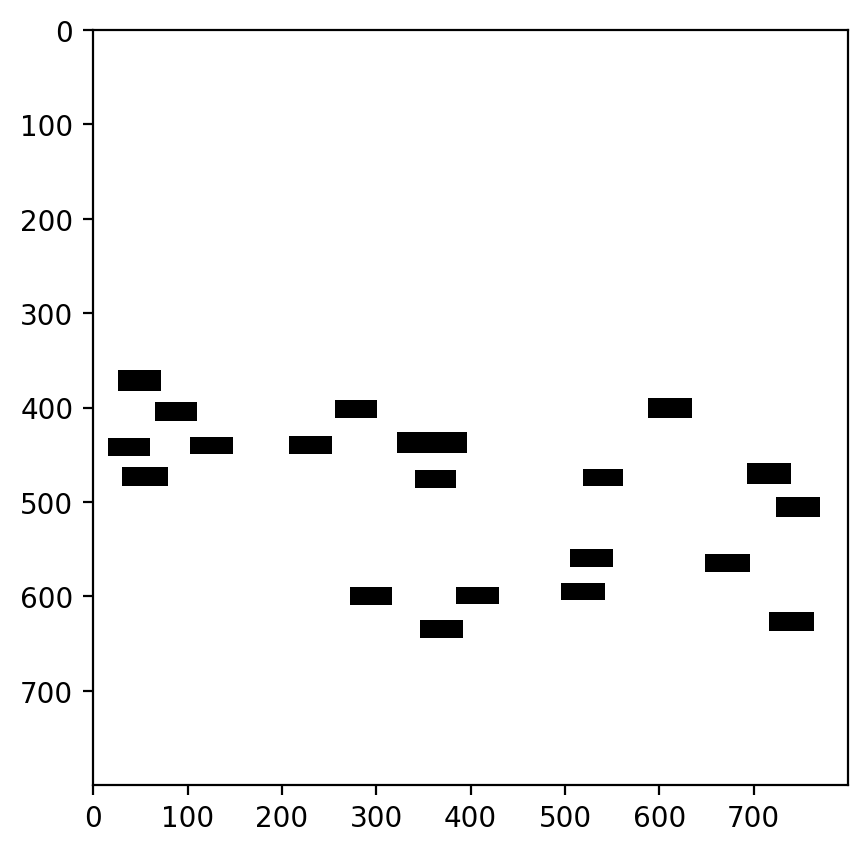

time: 1.52 s


In [13]:
#try plotting the targets

road_img = gen_result_chart(targets[0])
fig, ax = plt.subplots()
#color_list = ['b', 'g', 'orange', 'c', 'm', 'y', 'k', 'w', 'r']
 
ax.imshow(road_img, cmap ='binary')

In [14]:
dfsa

NameError: name 'dfsa' is not defined

time: 761 ms


In [ ]:
from torchvision.models.detection.rpn import AnchorGenerator
from torchvision.models.detection.rpn import RPNHead
def fr50_Model(pretrained = False):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=pretrained) #true works
    # create an anchor_generator for the FPN
    # which by default has 5 outputs
    anchor_generator = AnchorGenerator(
        #sizes=tuple([(16, 32, 64, 128, 256, 512) for _ in range(5)]),
        sizes=tuple([(10, 15, 20, 30, 40) for _ in range(5)]),
         
        aspect_ratios=tuple([(0.25, 0.5, 1.0, 2.0) for _ in range(5)]))
    
    
    
    model.rpn.anchor_generator = anchor_generator

    # 256 because that's the number of features that FPN returns
    model.rpn.head = RPNHead(256, anchor_generator.num_anchors_per_location()[0])
    return model

In [ ]:
## try training the a model with sew images non pannorm

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(True) #try true first

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
#check the output before training
images = [m.to(device) for m in images]
model.eval()
with torch.no_grad():
     prediction = model(images)

In [ ]:
prediction

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

In [ ]:
#give me another one
normalize = torchvision.transforms.Normalize(mean=[0.6394939, 0.6755114, 0.7049375],
                                 std=[0.31936955, 0.3117349 , 0.2953726 ])

tt = transforms.Compose([transforms.Resize((800, 800)), transforms.ToTensor(), normalize]) #this is for 6 images combo
for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(sew_images(s)).to(device) for s in sample] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

In [ ]:
model.eval()
with torch.no_grad():
     prediction = model(images)

In [ ]:
208.3556, 429.6745, 252.5559, 448.8516]

In [ ]:
prediction

In [ ]:
targets

In [ ]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#works with sewing 6 images with 
torch.save({

            'model_state_dict': model.state_dict(),
            }, "../models/fastRCNN_sew61epoch.pt")

In [ ]:
#try with panoramic images but reshaped to 800

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = sew_images_panorm(sample) #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        #targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

In [ ]:
images[0]

In [ ]:
#set up new training
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(True) #try true first

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100, panorm = True)
    # update the learning rate
    lr_scheduler.step()
    # evaluate on the test dataset - this has issues
    #evaluate(model, val_data_loader, device=device)

In [ ]:
#Evaluate on 1 sample

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(s).to(device) for s in sew_images_panorm(sample)] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

In [ ]:
model.eval()
with torch.no_grad():
     prediction = model(images)

In [ ]:
prediction

In [ ]:
targets

In [ ]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
sum([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [ ]:
#works with sewing 6 images with 
torch.save({

            'model_state_dict': model.state_dict(),
            }, "../models/fastRCNN_sewpanorm1epoch.pt")

In [ ]:
#try one without pretrained with reg sew images non panorm
 

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

# our dataset has two classes only - background and person
num_classes = 2 #4 returned classifier as nan

# get the model using our helper function
#model = get_instance_segmentation_model(num_classes)
model = fr50_Model(False) #try true first

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.0001, #reduce from 0.005 to help with the classifer loss = nan issue
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

In [ ]:
num_epochs = 1

for epoch in range(num_epochs):
    # train for one epoch, printing every 10 iterations
    train_one_epoch_FastRCNN(model, optimizer, train_data_loader, device, epoch, print_freq=100)
    # update the learning rate
    lr_scheduler.step()

In [ ]:
#Evaluate on 1 sample

for i, (sample, old_targets, road_image, extra) in enumerate(val_data_loader): #, print_freq, header): 
        
        images = [tt(sew_images(s)).to(device) for s in sample] #list of [3, 800, 800], should be 1 per patch
        targets = trans_target(old_targets)
        
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        break

In [ ]:
model.eval()
with torch.no_grad():
     prediction = model(images)

In [ ]:
prediction